In [3]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import config_reddit
import os
import time
from prawcore.exceptions import TooManyRequests

District of Columbia Government. (2024). Taxi Trips 2024. [Dataset]. Retrieved from https://dcgov.app.box.com/v/TaxiTrips2024

In [4]:
try:
    # Connect to MySQL
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="",
        database="taxi",
        charset="utf8"
    )

    if conn.is_connected():
        print("Connected to the database")

    query = """
        SELECT 
            DATE_FORMAT(origin_date, '%Y-%m') AS month, -- Extract year and month from the `origin_date`
            SUM(CASE WHEN airport = 'Y' THEN 1 ELSE 0 END) AS airport_taxi_users, -- Count users leaving airport
            ROUND(SUM(CASE WHEN airport = 'Y' THEN totalamount ELSE 0 END), 2) AS airport_taxi_total_revenue
        FROM test
        WHERE origin_date IS NOT NULL -- Exclude rows where origin_date is NULL
        GROUP BY DATE_FORMAT(origin_date, '%Y-%m') -- Group by year and month
        ORDER BY month;
    """

    # Execute SQL and load results into a DataFrame
    df = pd.read_sql(query, conn)
    print(df)

except mysql.connector.Error as err:
    print(f"Error connecting to the database: {err}")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    if conn.is_connected():
        conn.close()
        print("Database connection closed")

Connected to the database


C:\Users\Dell\AppData\Local\Temp\ipykernel_24708\1092187221.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


     month  airport_taxi_users  airport_taxi_total_revenue
0  2024-01             39170.0                  1102653.61
1  2024-02             45300.0                  1277027.13
2  2024-03             55882.0                  1639449.32
3  2024-04             60029.0                  1792334.34
4  2024-05             59148.0                  1793377.53
5  2024-06             51276.0                  1535262.08
6  2024-07             41713.0                  1270731.02
7  2024-08             40698.0                  1369979.92
Database connection closed


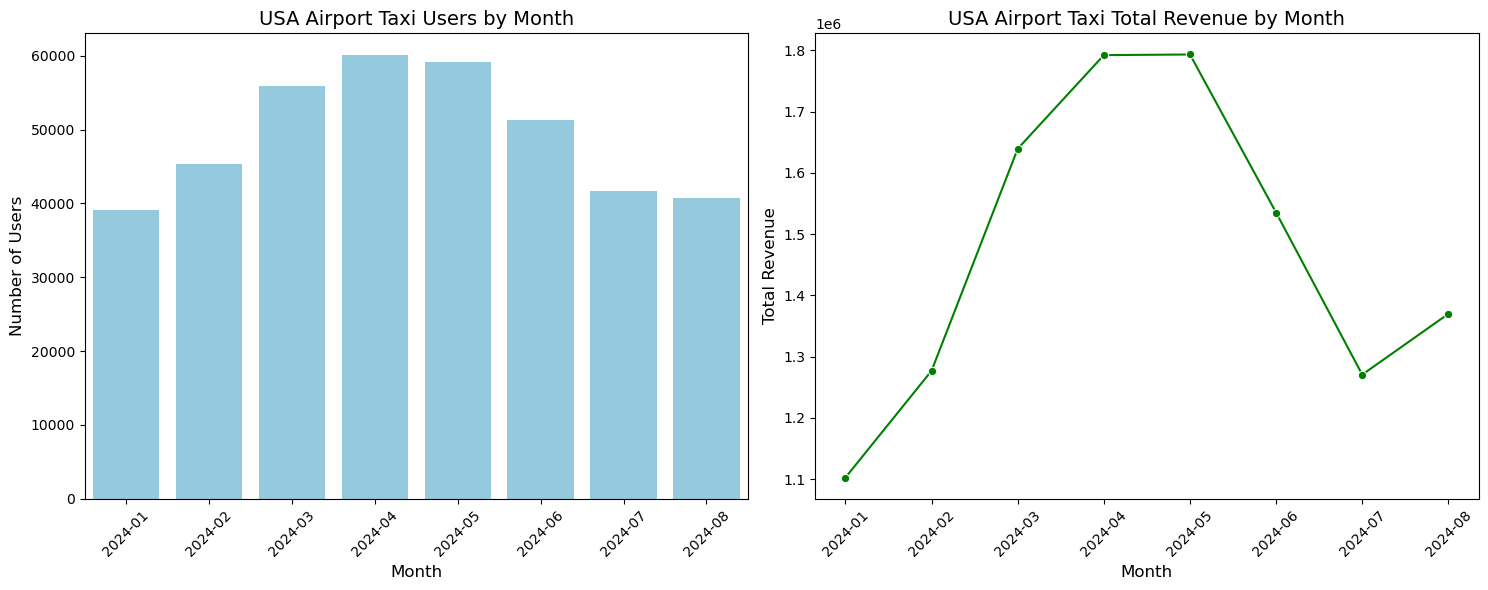

In [5]:
# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot - Bar plot for Airport Taxi Users
plt.subplot(1, 2, 1)
sns.barplot(x='month', y='airport_taxi_users', data=df, color='skyblue')
plt.title('USA Airport Taxi Users by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)

# Second subplot - Line plot for Airport Taxi Total Revenue
plt.subplot(1, 2, 2)
sns.lineplot(x='month', y='airport_taxi_total_revenue', data=df, color='green', marker='o')
plt.title('USA Airport Taxi Total Revenue by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

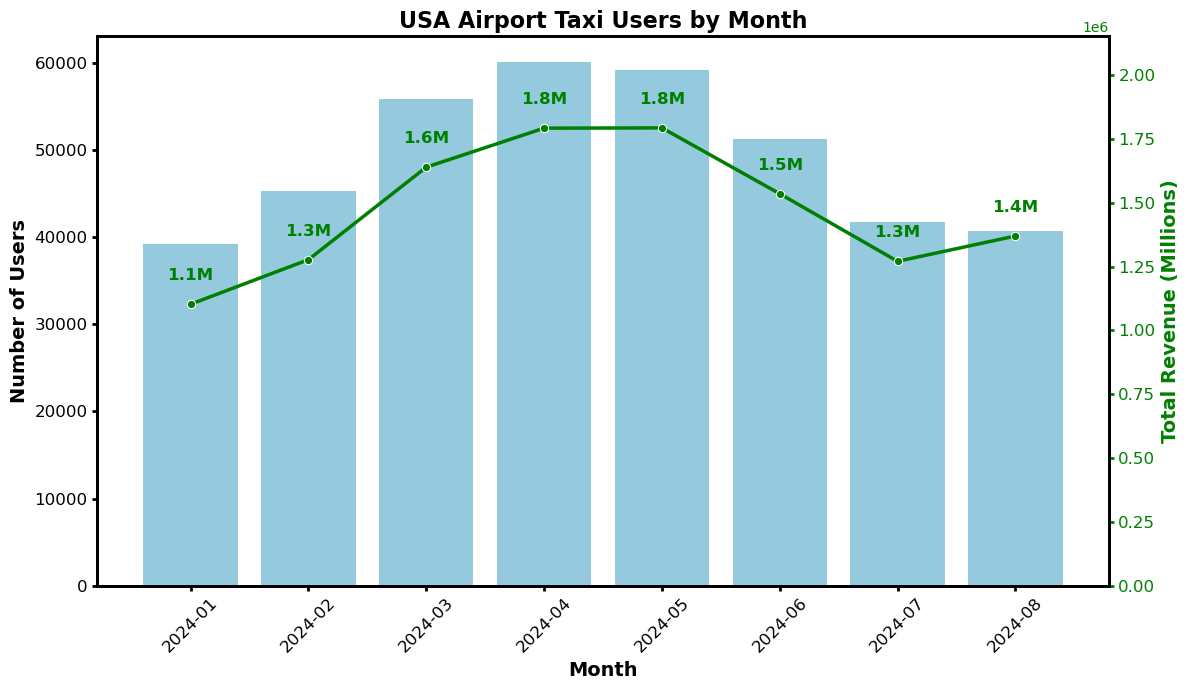

In [6]:
# Create a figure with the desired size
plt.figure(figsize=(12, 7))  # Increased figure height for better spacing

# Create a dual-axis plot
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot the airport taxi users as a bar chart
sns.barplot(x='month', y='airport_taxi_users', data=df, color='skyblue', ax=ax1)
ax1.set_title('USA Airport Taxi Users by Month', fontsize=16, fontweight='bold')
ax1.set_xlabel('Month', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', width=2, labelsize=12)

# Plot the airport taxi total revenue as a line plot
line = sns.lineplot(x='month', y='airport_taxi_total_revenue', data=df, color='green', marker='o', ax=ax2, linewidth=2.5)
ax2.set_ylabel('Total Revenue (Millions)', fontsize=14, fontweight='bold', color='green')
ax2.tick_params(axis='y', colors='green', width=2, labelsize=12)

# Adjust Y-axis limits to create more space above the highest point
ax2.set_ylim(0, df['airport_taxi_total_revenue'].max() * 1.2)  # Increase the upper limit by 20%

# Add revenue values as annotations
for i, revenue in enumerate(df['airport_taxi_total_revenue']):
    ax2.annotate(f'{revenue / 1e6:.1f}M', (i, revenue),  # Annotate with millions format
                 textcoords="offset points", xytext=(0, 15),  # Adjusted vertical offset
                 ha='center', va='bottom', color='green', fontsize=12, fontweight='bold')  # Larger, bold font

# Make axes thicker for better visibility
for spine in ax1.spines.values():
    spine.set_linewidth(2)
for spine in ax2.spines.values():
    spine.set_linewidth(2)

# Adjust the layout
plt.tight_layout()
plt.show()

In [9]:
# Reddit API Connection
reddit = praw.Reddit(user_agent    = f"Content exploration by {config_reddit.app_name}",
                     client_id     = config_reddit.app_id,
                     client_secret = config_reddit.app_secret)
reddit.read_only

# A function that performs sentiment analysis on text and returns a normalized score.
def analyze_sentiment(text):
    if text:
        scores = analyzer.polarity_scores(text)
        return scores['compound']  # Normalized score (-1 to 1)
    return 0

# A function that collects post data and comments for a given keyword and subreddit.
def collect_data_with_comments(keywords, subreddit_names, limit=100):
    posts_data = []
    for subreddit_name in subreddit_names:
        for keyword in keywords:
            retries = 3  # Maximum Retry Count
            while retries > 0:
                try:
                    # Reddit Post Search
                    for submission in reddit.subreddit(subreddit_name).search(keyword, limit=limit):
                        time.sleep(0.01)  # Leave a request interval
                        
                        # Get comments
                        comments = [
                            comment.body for comment in submission.comments
                            if isinstance(comment, praw.models.Comment)
                        ]
                        posts_data.append({
                            "subreddit": subreddit_name,
                            "title": submission.title,
                            "content": submission.selftext,
                            "score": submission.score,
                            "comments": comments,
                            "all_text": f"{submission.title} {submission.selftext} {' '.join(comments)}"
                        })
                    break  # If the operation is successful, exit the loop.
                except TooManyRequests as e:
                    # Catch 429 errors and get Retry-After
                    retry_after = int(e.response.headers.get("Retry-After", 10))  # Default: 10 seconds wait
                    print(f"429 Error: Too Many Requests. Retrying after {retry_after} seconds...")
                    time.sleep(retry_after)
                    retries -= 1
                except Exception as e:
                    print(f"An unexpected error occurred: {e}")
                    retries = 0  # For other errors, exit without retrying.

    return pd.DataFrame(posts_data)



# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()
    
    
# Function to count keywords
def count_keywords(texts, keywords):
    word_counts = Counter()
    for text in texts:
        for keyword in keywords:
            matches = re.findall(rf'\b{keyword}\b', text, flags=re.IGNORECASE)
            word_counts[keyword] += len(matches)
    return word_counts

# Sentiment Analysis Function using VADER
analyzer = SentimentIntensityAnalyzer()

# Step 2: Define Keywords and Collect Data
keywords_service = ["Expedia", "Expedia service", "Expedia experience"]
keywords_comparison = ["Expedia vs Agoda", "Expedia vs Booking", "Agoda reviews", "Booking reviews"]
subreddits = ["travel", "Flights", "TravelHacks"]

service_df = collect_data_with_comments(keywords_service, subreddits)
comparison_df = collect_data_with_comments(keywords_comparison, subreddits)


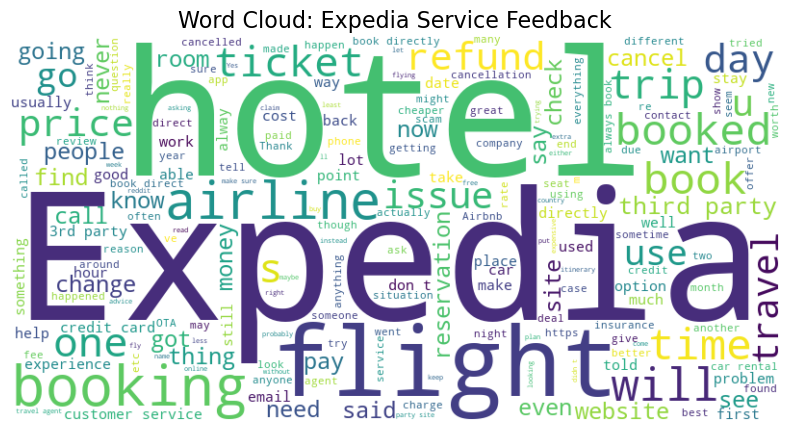

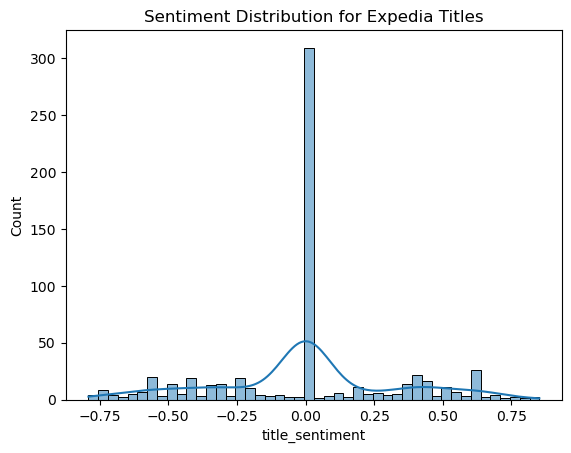

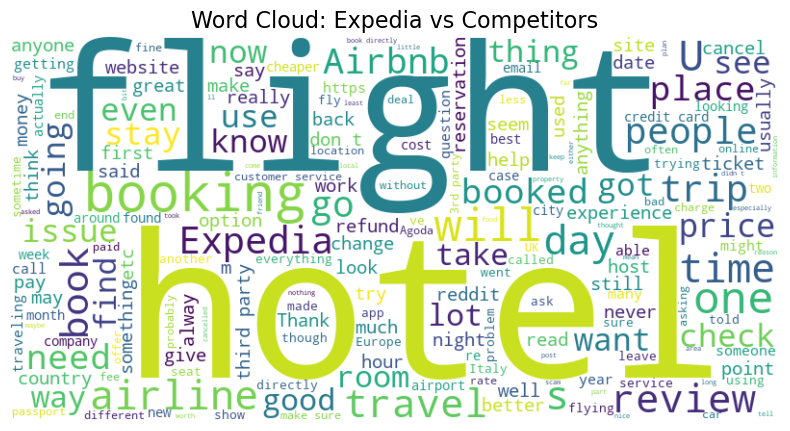

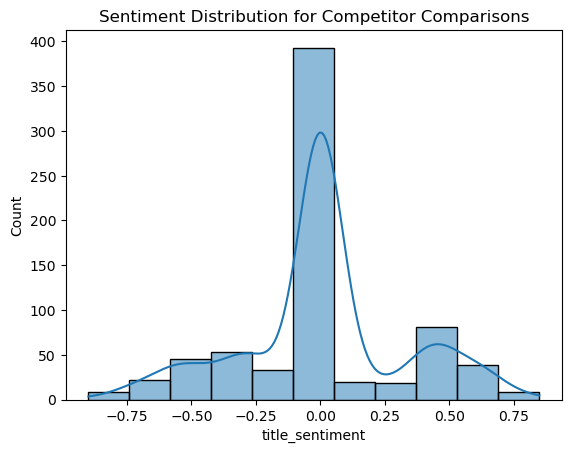

Average sentiment - Service: 0.30, Comparison: 0.35


In [18]:
# If service_df is empty
if not service_df.empty:
    # Analyze sentiment
    service_df["title_sentiment"] = service_df["title"].apply(analyze_sentiment)
    service_df["content_sentiment"] = service_df["content"].apply(analyze_sentiment)
    service_df["comments_sentiment"] = service_df["comments"].apply(lambda x: analyze_sentiment(" ".join(x)))
    
    # Generate word cloud
    all_text_service = " ".join(service_df["all_text"].tolist())
    generate_word_cloud(all_text_service, "Word Cloud: Expedia Service Feedback")
    
    # Visualize sentiment distribution
    sns.histplot(service_df["title_sentiment"], kde=True)
    plt.title("Sentiment Distribution for Expedia Titles")
    plt.show()

# If comparison_df is empty
if not comparison_df.empty:
    # Analyze sentiment
    comparison_df["title_sentiment"] = comparison_df["title"].apply(analyze_sentiment)
    comparison_df["content_sentiment"] = comparison_df["content"].apply(analyze_sentiment)
    comparison_df["comments_sentiment"] = comparison_df["comments"].apply(lambda x: analyze_sentiment(" ".join(x)))
    
    # Generate word cloud
    all_text_comparison = " ".join(comparison_df["all_text"].tolist())
    generate_word_cloud(all_text_comparison, "Word Cloud: Expedia vs Competitors")
    
    # Visualize sentiment distribution
    sns.histplot(comparison_df["title_sentiment"], kde=True)
    plt.title("Sentiment Distribution for Competitor Comparisons")
    plt.show()

# Run the operation only if both data frames are non-empty
if not service_df.empty and not comparison_df.empty:
    avg_sentiment_service = service_df["content_sentiment"].mean()
    avg_sentiment_comparison = comparison_df["content_sentiment"].mean()
    print(f"Average sentiment - Service: {avg_sentiment_service:.2f}, Comparison: {avg_sentiment_comparison:.2f}")

In [11]:
# file path
file_name = "most-visited-countries-2024.csv"
file_path = os.path.join("./", file_name)

try:
    # Read CSV file
    df = pd.read_csv(file_path)
    print(f"{file_name} successfully loaded.")
    
except FileNotFoundError:
    print(f"{file_name} not found. Please check the path.")
except Exception as e:
    print(f"An error has occured.: {str(e)}")

most-visited-countries-2024.csv successfully loaded.


In [12]:
# Create a column that sums the arrivals for 2023 and 2022.
df["Total_Arrivals_2023_2022"] = df["MostVisited_NumOfArrivals_Millions_2023"] + df["MostVisited_NumOfArrivals_Millions_2022"]
    
# Extracte the top 10 based on the total
top_30 = df.sort_values(by="Total_Arrivals_2023_2022", ascending=False).head(30)
    
# Show the result
print("TOP 30 Ranking:")
print(top_30[["country", "Total_Arrivals_2023_2022"]])

TOP 30 Ranking:
                 country  Total_Arrivals_2023_2022
22                France                    179.40
31                 Spain                    156.83
2          United States                    117.35
24                 Italy                    107.06
10                Mexico                     80.48
20        United Kingdom                     67.96
18               Germany                     63.26
90                Greece                     60.58
94               Austria                     57.12
81  United Arab Emirates                     50.80
88              Portugal                     48.79
46          Saudi Arabia                     44.07
67           Netherlands                     36.37
37                Poland                     34.94
36                Canada                     31.16
12                 Egypt                     26.57
91               Hungary                     25.58
0                  India                       NaN
1              

In [13]:
# Replace missing values with zero
df["MostVisited_NumOfArrivals_Millions_2023"].fillna(0, inplace=True)
df["MostVisited_NumOfArrivals_Millions_2022"].fillna(0, inplace=True)

# Recalculate the total
df["Total_Arrivals_2023_2022"] = df["MostVisited_NumOfArrivals_Millions_2023"] + df["MostVisited_NumOfArrivals_Millions_2022"]

# Acquire TOP 30
top_30 = df.sort_values(by="Total_Arrivals_2023_2022", ascending=False).head(30)
print(top_30[["country", "Total_Arrivals_2023_2022"]])

                  country  Total_Arrivals_2023_2022
22                 France                    179.40
31                  Spain                    156.83
2           United States                    117.35
24                  Italy                    107.06
10                 Mexico                     80.48
20         United Kingdom                     67.96
18                Germany                     63.26
90                 Greece                     60.58
94                Austria                     57.12
81   United Arab Emirates                     50.80
17                 Turkey                     50.45
88               Portugal                     48.79
46           Saudi Arabia                     44.07
67            Netherlands                     36.37
37                 Poland                     34.94
36                 Canada                     31.16
19               Thailand                     28.15
12                  Egypt                     26.57
91          

C:\Users\Dell\AppData\Local\Temp\ipykernel_6980\3918273447.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["MostVisited_NumOfArrivals_Millions_2023"].fillna(0, inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_6980\3918273447.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

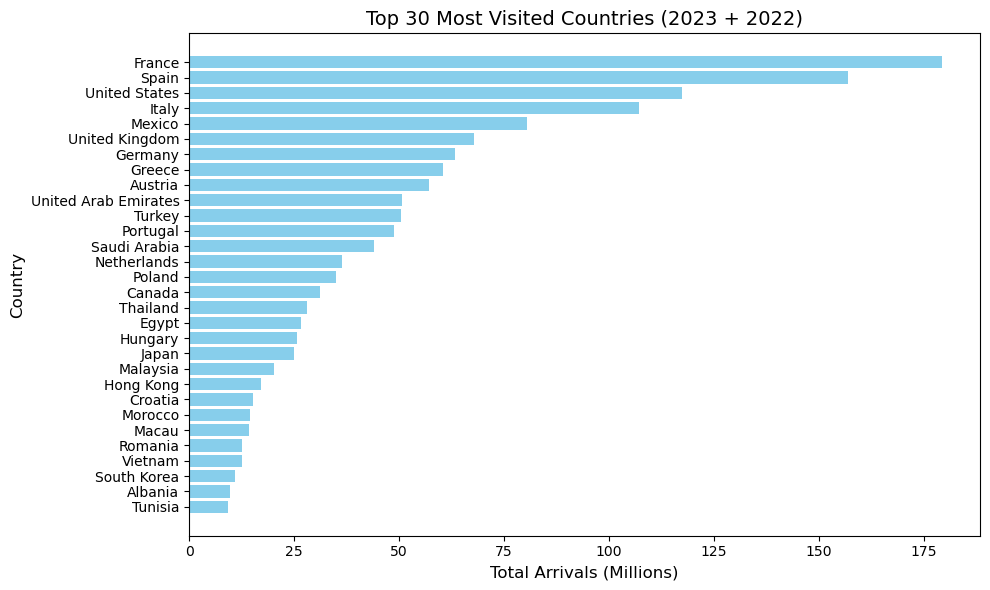

In [14]:
# plot
plt.figure(figsize=(10, 6))  # Adjust height
plt.barh(top_30["country"], top_30["Total_Arrivals_2023_2022"], color='skyblue')
plt.title("Top 30 Most Visited Countries (2023 + 2022)", fontsize=14)
plt.xlabel("Total Arrivals (Millions)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()